In [75]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re 

In [76]:
# import and analyse dataset
labels = pd.read_csv('labels_and_ids.csv')
labels.groupby('jericho_human_classification').size()

jericho_human_classification
ham      590
phish     22
spam     539
dtype: int64

In [77]:
# flatten inbound_event_ids
labels.loc[:, 'inbound_event_ids'] = labels['inbound_event_ids'].apply(lambda x: x.removeprefix('[').removesuffix(']').split(','))
labels = labels.explode('inbound_event_ids')
# remove duplicates
labels = labels.drop_duplicates(subset='inbound_event_ids')
# convert inbound_event_ids to int
labels.loc[:, 'inbound_event_ids'] = labels['inbound_event_ids'].astype(int)
# down sample to match phish
ham_labels = labels[labels['jericho_human_classification'] == 'ham']
spam_labels = labels[labels['jericho_human_classification'] == 'spam']
phish_labels = labels[labels['jericho_human_classification'] == 'phish']
print(ham_labels.shape, spam_labels.shape, phish_labels.shape)
ham_labels = ham_labels.sample(n=phish_labels.shape[0], random_state=42)
spam_labels = spam_labels.sample(n=phish_labels.shape[0], random_state=42)
labels = pd.concat([ham_labels, spam_labels, phish_labels])
labels.info()
# save to ids to text
for i in labels['inbound_event_ids']:
    with open('ids.txt', 'a') as f:
        f.write(f'{i},')


(728, 3) (556, 3) (25, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 75 entries, 114 to 1148
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   id                            75 non-null     int64 
 1   jericho_human_classification  75 non-null     object
 2   inbound_event_ids             75 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.3+ KB


In [78]:
obj_df = pd.read_csv('email_data.csv')
# merge with labels
obj_df = obj_df.merge(labels, left_on='id', right_on='inbound_event_ids')
obj_df = obj_df.drop(columns=['id_x', 'id_y'])
obj_df['processed_body'] = obj_df['processed_body'].astype(str)
obj_df['processed_subject'] = obj_df['processed_subject'].astype(str)
obj_df['jericho_human_classification'] = obj_df['jericho_human_classification'].astype(str)
obj_df['inbound_event_ids'] = obj_df['inbound_event_ids'].astype(int)
obj_df.head()

,from,processed_subject,processed_body,payload,jericho_human_classification,inbound_event_ids
0,no-reply@rentaequipospiedra.cl,9192-Jerichosecurity: Accept the proposal and ...,Docusign He‌llo sage@jerichosecurity.com\nYo‌u...,"{""cc"":"""",""to"":""sage@jerichosecurity.com"",""bcc""...",phish,208
1,deep@beeleads.com,Life of a Prospect- A Journey of Multiple Purc...,Life of a Prospect- A Journey of Multiple Purc...,"{""cc"":"""",""to"":""alyssa.davis@jerichosecurity.co...",spam,402
2,no-reply@zoom.us,Ahmad Anderson has joined your meeting - Sales...,"Hi Madison Martin, Ahmad Anderson has joined...","{""cc"":"""",""to"":""madison@jerichosecurity.com"",""b...",ham,501
3,telmalogistics@gmail.com,Sage Wohns,Chris\n---\n\nI need you to kindly leave your ...,"{""cc"":"""",""to"":""chris@jerichosecurity.com"",""bcc...",phish,509
4,attendurgent@gmail.com,Sage Wohns,"Hello Chris,\n\n I have a task for you to comp...","{""cc"":"""",""to"":""chris@jerichosecurity.com"",""bcc...",phish,638


In [79]:
# preparation of data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
encoder = LabelEncoder()
def simplify_text(text):
    text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    # remove non text characters
    text = ''.join([i for i in text if i.isalnum() or i == ' '])
    return text
def count_generic_greeting(text):
    count = 0
    generic_references = [
    "customer",
    "friend",
    "user",
    "sir",
    "madam",
    "member",
    "client",
    "beneficiary",
    "subscriber",
    "account holder",
    "colleague",
    "team member",
    "partner",
    "recipient",
    "patron"
    ]
    for ref in generic_references:
        count += text.lower().count(ref)
    return count

obj_df['processed_body'] = obj_df['processed_body'].apply(simplify_text)
obj_df['processed_subject'] = obj_df['processed_subject'].apply(simplify_text)
obj_df['jericho_human_classification'] = encoder.fit_transform(obj_df['jericho_human_classification'])
sender = obj_df['from'].apply(lambda x: x.split('@')[0])
sender_domain = obj_df['from'].apply(lambda x: x.split('@')[1])
sender = CountVectorizer().fit_transform(sender)
sender_domain = CountVectorizer().fit_transform(sender_domain)
vectorized_subject = CountVectorizer().fit_transform(obj_df['processed_subject'])
# additional features
has_noreply = obj_df['payload'].apply(lambda x: 1 if 'noreply' in x else 0)
spf_pass = obj_df['payload'].apply(lambda x: 1 if 'spf=pass' in x else 0)
spf_fail = obj_df['payload'].apply(lambda x: 1 if 'spf=fail' in x else 0)
dkim_pass = obj_df['payload'].apply(lambda x: 1 if 'dkim=pass' in x else 0)
dkim_fail = obj_df['payload'].apply(lambda x: 1 if 'dkim=fail' in x else 0)
dmarc_pass = obj_df['payload'].apply(lambda x: 1 if 'dmarc=pass' in x else 0)
dmarc_fail = obj_df['payload'].apply(lambda x: 1 if 'dmarc=fail' in x else 0)
generic_greetings = obj_df['processed_body'].apply(count_generic_greeting)

In [ ]:
X = np.concatenate((sender.toarray(), sender_domain.toarray(), vectorized_subject.toarray(), dataset.drop(columns='classification').values), axis=1)
y_true = []
y_pred = []
loo = LeaveOneOut()
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    y_pred.append(clf.predict(X_test))
    y_true.append(y_test)

print(classification_report(y_true, y_pred, target_names=encoder.classes_))

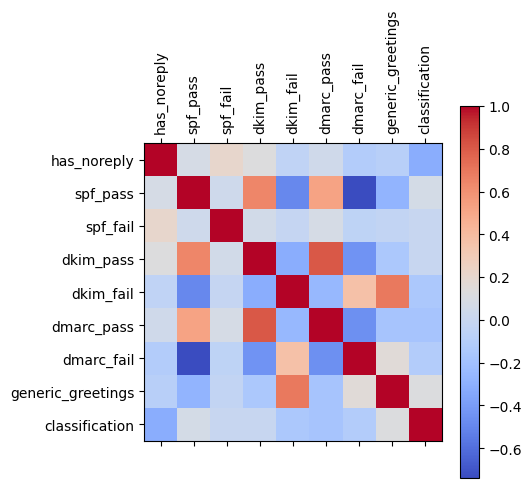

In [91]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

dataset = pd.DataFrame({ 'has_noreply': has_noreply,
                        'spf_pass': spf_pass,
                        'spf_fail': spf_fail,
                        'dkim_pass': dkim_pass,
                        'dkim_fail': dkim_fail,
                        'dmarc_pass': dmarc_pass,
                        'dmarc_fail': dmarc_fail,
                        'generic_greetings': generic_greetings,
                        'classification': obj_df['jericho_human_classification']})
corr = dataset.corr()
plt.matshow(corr, cmap='coolwarm')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
cb = plt.colorbar()
# show column names